# Chronic Heart Diseases Classification

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, confusion_matrix, plot_roc_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import AdaBoostClassifier
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan
    try: score = actual_scorer(y_true, y_pred)
    except Exception: pass
    return score

mcc = make_scorer(custom_scorer, actual_scorer = matthews_corrcoef)

### EDA

In [3]:
heart_df = pd.read_csv('../data/Framingham.csv', engine = 'python')
heart_df = heart_df.dropna(axis = 0)

heart_df['male'] = heart_df['male'].astype('category')
heart_df['education'] = heart_df['education'].astype('category')
heart_df['current_smoker'] = heart_df['current_smoker'].astype(int).astype('category')
heart_df['bp_meds'] = heart_df['bp_meds'].astype(int).astype('category')
heart_df['prevalent_stroke'] = heart_df['prevalent_stroke'].astype(int).astype('category')
heart_df['prevalent_hyper'] = heart_df['prevalent_hyper'].astype(int).astype('category')
heart_df['diabetes'] = heart_df['diabetes'].astype(int).astype('category')
heart_df['ten_year_chd'] = heart_df['ten_year_chd'].astype(int).astype('category')

heart_df.head()

,male,age,education,current_smoker,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyper,diabetes,total_chol,sys_bp,dia_bp,bmi,heart_rate,glucose,ten_year_chd
0,1,39,College,0,0.0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,High School or GED,0,0.0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,Some High School,1,20.0,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,Some College or Vocational School,1,30.0,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,Some College or Vocational School,1,23.0,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
heart_df.select_dtypes(exclude = ['category']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,3658.0,49.551941,8.562029,32.00,42.00,49.00,56.0000,70.0
cigs_per_day,3658.0,9.025424,11.921590,0.00,0.00,0.00,20.0000,70.0
total_chol,3658.0,236.847731,44.097681,113.00,206.00,234.00,263.0000,600.0
sys_bp,3658.0,132.370558,22.086866,83.50,117.00,128.00,143.8750,295.0
dia_bp,3658.0,82.917031,11.974258,48.00,75.00,82.00,90.0000,142.5
bmi,3658.0,25.782802,4.065601,15.54,23.08,25.38,28.0375,56.8
heart_rate,3658.0,75.730727,11.981525,44.00,68.00,75.00,82.0000,143.0
glucose,3658.0,81.852925,23.904164,40.00,71.00,78.00,87.0000,394.0


In [5]:
heart_df.select_dtypes(include = ['category']).describe().transpose()

,count,unique,top,freq
male,3658,2,0,2035
education,3658,4,Some High School,1526
current_smoker,3658,2,0,1869
bp_meds,3658,2,0,3547
prevalent_stroke,3658,2,0,3637
prevalent_hyper,3658,2,0,2518
diabetes,3658,2,0,3559
ten_year_chd,3658,2,0,3101


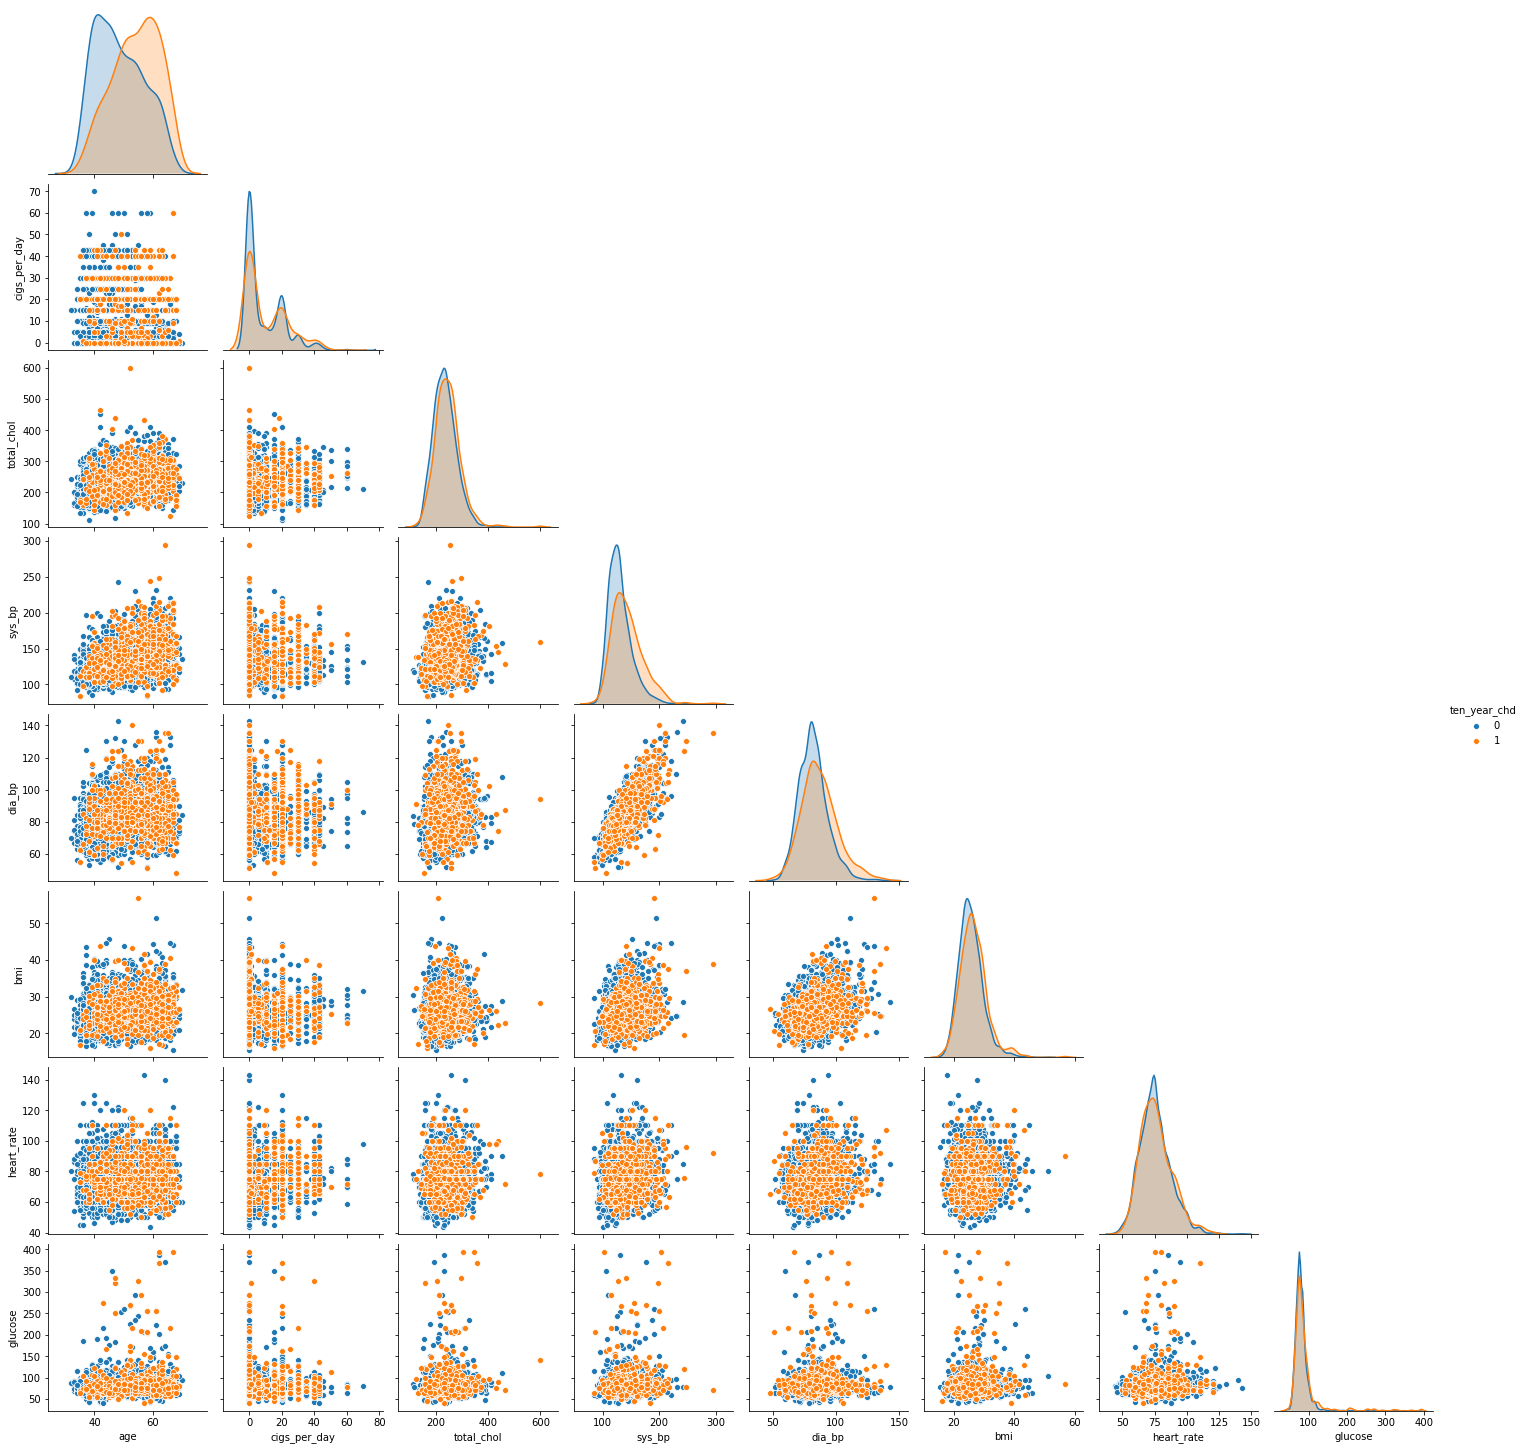

In [6]:
sns.pairplot(heart_df[list(heart_df.dtypes[(heart_df.dtypes == 'category') == False].index) + ['ten_year_chd']], 
             hue = 'ten_year_chd', corner = True)
plt.show()

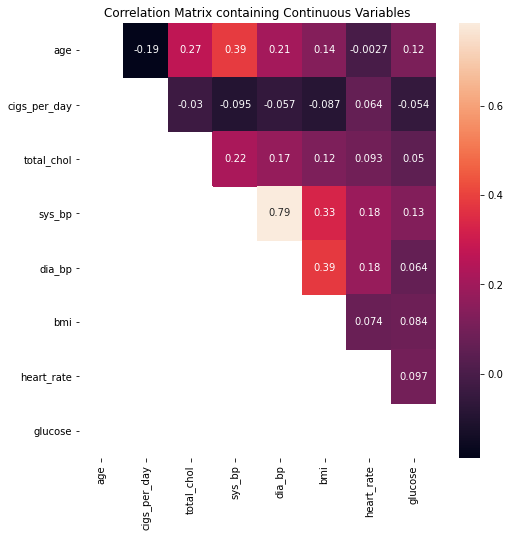

In [7]:
mask = np.zeros_like(heart_df.select_dtypes(exclude = ['category']).corr())
mask[np.tril_indices_from(mask)] = 1
plt.figure(figsize=(8, 8))
sns.heatmap(heart_df.select_dtypes(exclude = ['category']).corr(), mask = mask, annot = True, square = False)
plt.title('Correlation Matrix containing Continuous Variables')
plt.show()

In [8]:
X = add_constant(heart_df)
X = X.select_dtypes(exclude = ['category'])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)

const           127.752134
age               1.315494
cigs_per_day      1.048542
total_chol        1.106154
sys_bp            3.109630
dia_bp            2.860657
bmi               1.190182
heart_rate        1.062395
glucose           1.038703
dtype: float64

None of the continuous variables are correlated as the highest VIF is less than 10.

### Preprocessing

In [9]:
full_df = heart_df

full_ddf = pd.get_dummies(full_df['education'], drop_first = True, prefix = 'edu:')
full_ddf = pd.concat([full_ddf, full_df[['male', 'current_smoker', 'bp_meds', 'prevalent_stroke', 
                                         'prevalent_hyper', 'diabetes']]], axis = 1)

full_df = full_df.drop(['education', 'male', 'current_smoker', 'bp_meds', 'prevalent_stroke', 
                        'prevalent_hyper', 'diabetes'], axis = 1)

c = pd.DataFrame(full_df['ten_year_chd']).reset_index(drop = True)

full_df = full_df.drop('ten_year_chd', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X1 = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)
X2 = pd.concat([full_df, full_ddf], axis = 1).reset_index(drop = True)

In [10]:
random.seed(42)
X1_train = X1.sample(frac = 0.7).sort_index()
X2_train = X2[X1.index.isin(X1_train.index)]
c_train = c[X1.index.isin(X1_train.index)]
X1_test = X1[~X1.index.isin(X1_train.index)]
X2_test = X2[~X1.index.isin(X1_train.index)]
c_test = c[~X1.index.isin(X1_train.index)]

### Support Vector Classification using Linear Kernel

In [11]:
lsvc_reg_arr = np.logspace(-3, 3, 7)

lsvc = GridSearchCV(SVC(kernel = 'linear', class_weight = 'balanced'), 
                    param_grid = {'C' : lsvc_reg_arr}, 
                    scoring = mcc, cv = 5, return_train_score = True)

lsvc.fit(X1_train.values, c_train.values.ravel())

lsvc_df = pd.DataFrame(lsvc.cv_results_)

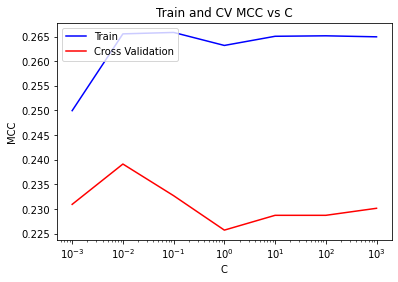

In [12]:
plt.plot(lsvc_df['param_C'], lsvc_df['mean_train_score'], c = 'b', label = 'Train')
plt.plot(lsvc_df['param_C'], lsvc_df['mean_test_score'], c = 'r', label = 'Cross Validation')
plt.xscale('log')
plt.legend(loc = 2)
plt.xlabel('C')
plt.ylabel('MCC')
plt.title('Train and CV MCC vs C')
plt.show()

Best Parameters: {'C': 0.01}
Best Cross-Validation MCC: 0.24


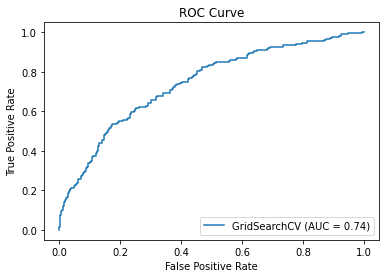

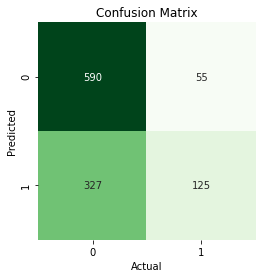

Accuracy: 0.65
Sensitivity: 0.69
Specificity: 0.64


In [13]:
print('Best Parameters: {}'.format(lsvc.best_params_))
print('Best Cross-Validation MCC: {:.2f}'.format(lsvc.best_score_))

pred_lsvc = lsvc.predict(X1_test)

plot_roc_curve(lsvc, X1_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_lsvc = confusion_matrix(c_test, pred_lsvc)
tn, fp, fn, tp = cm_lsvc.ravel()

ax = sns.heatmap(cm_lsvc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_lsvc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### Support Vector Classification using Radial Kernel

In [14]:
rsvc_reg_arr = np.logspace(-3, 2, 6)
rsvc_gamma_arr = np.logspace(-3, 2, 6)

rsvc = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), 
                    param_grid = {'C' : rsvc_reg_arr, 'gamma' : rsvc_gamma_arr}, 
                    scoring = mcc, cv = 5, return_train_score = True)

rsvc.fit(X1_train.values, c_train.values.ravel())

rsvc_df = pd.DataFrame(rsvc.cv_results_)

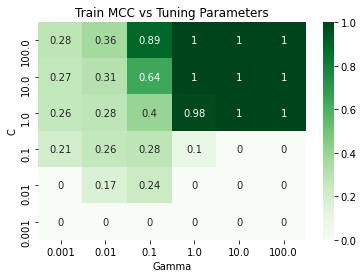

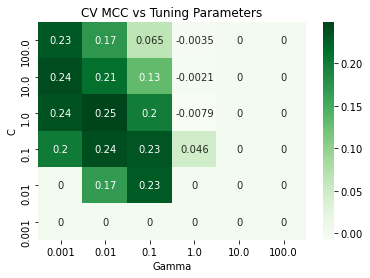

In [15]:
rsvc_train_err_mat = rsvc_df['mean_train_score'].values.reshape(len(rsvc_reg_arr), len(rsvc_gamma_arr))
ax = sns.heatmap(pd.DataFrame(rsvc_train_err_mat, columns = rsvc_gamma_arr, index = rsvc_reg_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'Train MCC vs Tuning Parameters')
plt.show()

rsvc_cv_err_mat = rsvc_df['mean_test_score'].values.reshape(len(rsvc_reg_arr), len(rsvc_gamma_arr))
ax = sns.heatmap(pd.DataFrame(rsvc_cv_err_mat, columns = rsvc_gamma_arr, index = rsvc_reg_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'CV MCC vs Tuning Parameters')
plt.show()

In [16]:
# fig = plt.figure(figsize = (6, 6))
# ax = fig.gca(projection = '3d')
# ax.plot_trisurf(np.log10(rsvc_df['param_C'].values.astype(float)), 
#                 np.log10(rsvc_df['param_gamma'].values.astype(float)), 
#                 rsvc_df['mean_test_score'], cmap = plt.cm.viridis, linewidth = 0.2)
# ax.set(xlabel ='C', ylabel = 'Gamma', zlabel = 'CV MCC', title = 'CV MCC vs Tuning Parameters')
# ax.set_xticks(range(len(rsvc_reg_arr)))
# ax.set_xticklabels(rsvc_reg_arr)
# ax.set_yticks(range(len(rsvc_gamma_arr)))
# ax.set_yticklabels(rsvc_gamma_arr)
# plt.show()

Best Parameters: {'C': 1.0, 'gamma': 0.01}
Best Cross-Validation MCC: 0.25


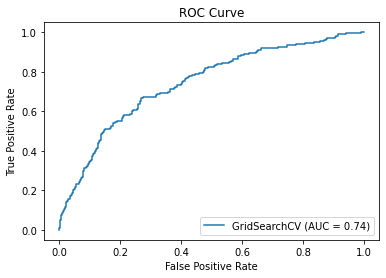

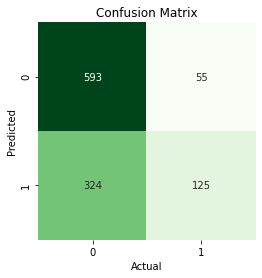

Accuracy: 0.65
Sensitivity: 0.69
Specificity: 0.65


In [17]:
print('Best Parameters: {}'.format(rsvc.best_params_))
print('Best Cross-Validation MCC: {:.2f}'.format(rsvc.best_score_))

pred_rsvc = rsvc.predict(X1_test)

plot_roc_curve(rsvc, X1_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_rsvc = confusion_matrix(c_test, pred_rsvc)
tn, fp, fn, tp = cm_rsvc.ravel()

ax = sns.heatmap(cm_rsvc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_rsvc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### Support Vector Classification using Polynomial Kernel

In [18]:
psvc_reg_arr = np.logspace(-3, 1, 5)
psvc_gamma_arr = np.logspace(-2, 2, 5)
psvc_degree_arr = np.linspace(1, 4, 4)

psvc = GridSearchCV(SVC(kernel = 'poly', class_weight = 'balanced', max_iter = 10000), 
                    param_grid = {'C': psvc_reg_arr, 'gamma' : psvc_gamma_arr, 'degree' : psvc_degree_arr}, 
                    scoring = mcc, cv = 5, return_train_score = True)

psvc.fit(X1_train.values, c_train.values.ravel())

psvc_df = pd.DataFrame(psvc.cv_results_)

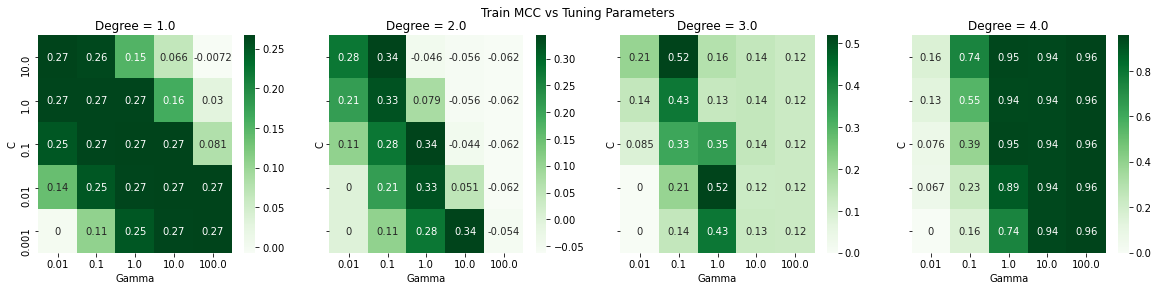

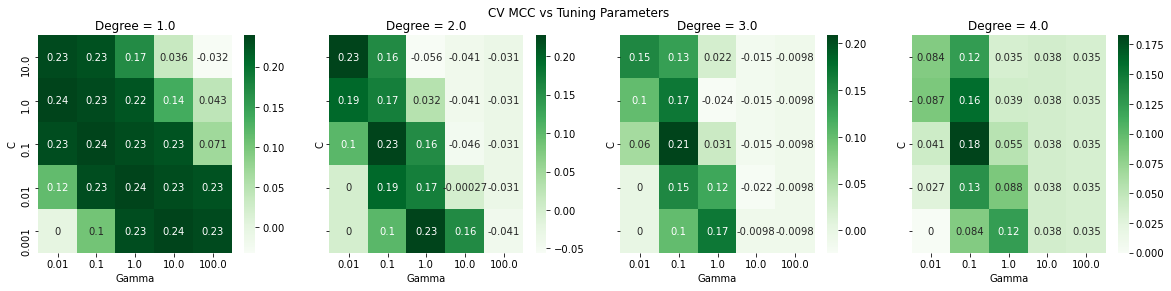

In [19]:
fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (20, 4))
for ax, degree in zip(axs.ravel(), psvc_degree_arr):
    psvc_deg_df = psvc_df[psvc_df['param_degree'] == degree]
    psvc_deg_train_err_mat = psvc_deg_df['mean_train_score'].values.reshape(len(psvc_reg_arr), len(psvc_gamma_arr))
    ax = sns.heatmap(pd.DataFrame(psvc_deg_train_err_mat, columns = psvc_gamma_arr, index = psvc_reg_arr).iloc[::-1], 
                     ax = ax, annot = True, cmap = 'Greens')
    ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'Degree = ' + str(degree))
fig.suptitle('Train MCC vs Tuning Parameters')
plt.show()

fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (20, 4))
for ax, degree in zip(axs.ravel(), psvc_degree_arr):
    psvc_deg_df = psvc_df[psvc_df['param_degree'] == degree]
    psvc_deg_cv_err_mat = psvc_deg_df['mean_test_score'].values.reshape(len(psvc_reg_arr), len(psvc_gamma_arr))
    ax = sns.heatmap(pd.DataFrame(psvc_deg_cv_err_mat, columns = psvc_gamma_arr, index = psvc_reg_arr).iloc[::-1], 
                     ax = ax, annot = True, cmap = 'Greens')
    ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'Degree = ' + str(degree))
fig.suptitle('CV MCC vs Tuning Parameters')
plt.show()

Best Parameters: {'C': 0.001, 'degree': 1.0, 'gamma': 10.0}
Best Cross-Validation MCC: 0.24


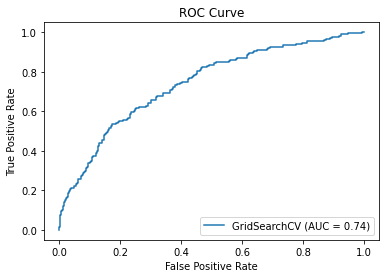

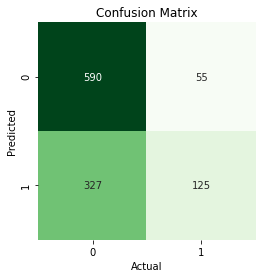

Accuracy: 0.65
Sensitivity: 0.69
Specificity: 0.64


In [20]:
print('Best Parameters: {}'.format(psvc.best_params_))
print('Best Cross-Validation MCC: {:.2f}'.format(psvc.best_score_))

pred_psvc = psvc.predict(X1_test)

plot_roc_curve(psvc, X1_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_psvc = confusion_matrix(c_test, pred_psvc)
tn, fp, fn, tp = cm_psvc.ravel()

ax = sns.heatmap(cm_psvc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_psvc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### Decision Tree Classification

In [21]:
dt_criterion = ['gini','entropy']
dt_max_depth_arr = np.linspace(1, 10, 10).astype(int)
dt_min_leaf_arr = np.linspace(1, 10, 10).astype(int)

dt = GridSearchCV(DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'), 
                  param_grid = {'criterion': dt_criterion, 
                                'max_depth' : dt_max_depth_arr, 
                                'min_samples_leaf' : dt_min_leaf_arr}, 
                  scoring = mcc, cv = 5, return_train_score = True)

dt.fit(X2_train, c_train)

dt_df = pd.DataFrame(dt.cv_results_)

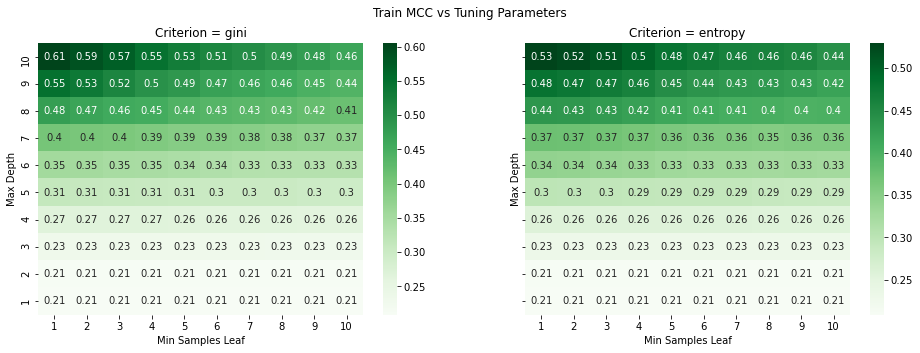

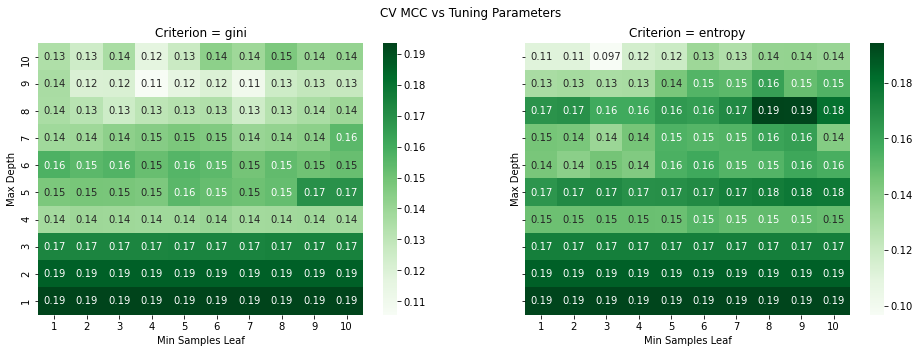

In [22]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 5))
for ax, criterion in zip(axs.ravel(), dt_criterion):
    dt_criterion_df = dt_df[dt_df['param_criterion'] == criterion]
    dt_criterion_train_err_mat = dt_criterion_df['mean_train_score'].values.reshape(len(dt_max_depth_arr), 
                                                                                    len(dt_min_leaf_arr))
    ax = sns.heatmap(pd.DataFrame(dt_criterion_train_err_mat, columns = dt_min_leaf_arr, 
                                  index = dt_max_depth_arr).iloc[::-1], ax = ax, annot = True, cmap = 'Greens')
    ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Criterion = ' + str(criterion))
fig.suptitle('Train MCC vs Tuning Parameters')
plt.show()

fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 5))
for ax, criterion in zip(axs.ravel(), dt_criterion):
    dt_criterion_df = dt_df[dt_df['param_criterion'] == criterion]
    dt_criterion_cv_err_mat = dt_criterion_df['mean_test_score'].values.reshape(len(dt_max_depth_arr), len(dt_min_leaf_arr))
    ax = sns.heatmap(pd.DataFrame(dt_criterion_cv_err_mat, columns = dt_min_leaf_arr, 
                                  index = dt_max_depth_arr).iloc[::-1], ax = ax, annot = True, cmap = 'Greens')
    ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Criterion = ' + str(criterion))
fig.suptitle('CV MCC vs Tuning Parameters')
plt.show()

Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 8}
Best Cross-Validation MCC: 0.19


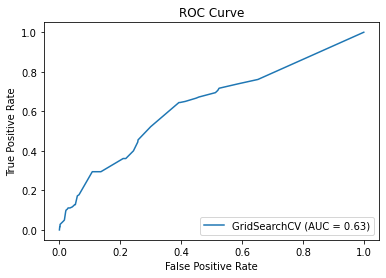

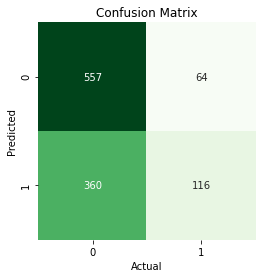

Accuracy: 0.61
Sensitivity: 0.64
Specificity: 0.61


In [23]:
print("Best Parameters: {}".format(dt.best_params_))
print("Best Cross-Validation MCC: {:.2f}".format(dt.best_score_))

pred_dt = dt.predict(X2_test)

plot_roc_curve(dt, X2_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_dt = confusion_matrix(c_test, pred_dt)
tn, fp, fn, tp = cm_dt.ravel()

ax = sns.heatmap(cm_dt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_dt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

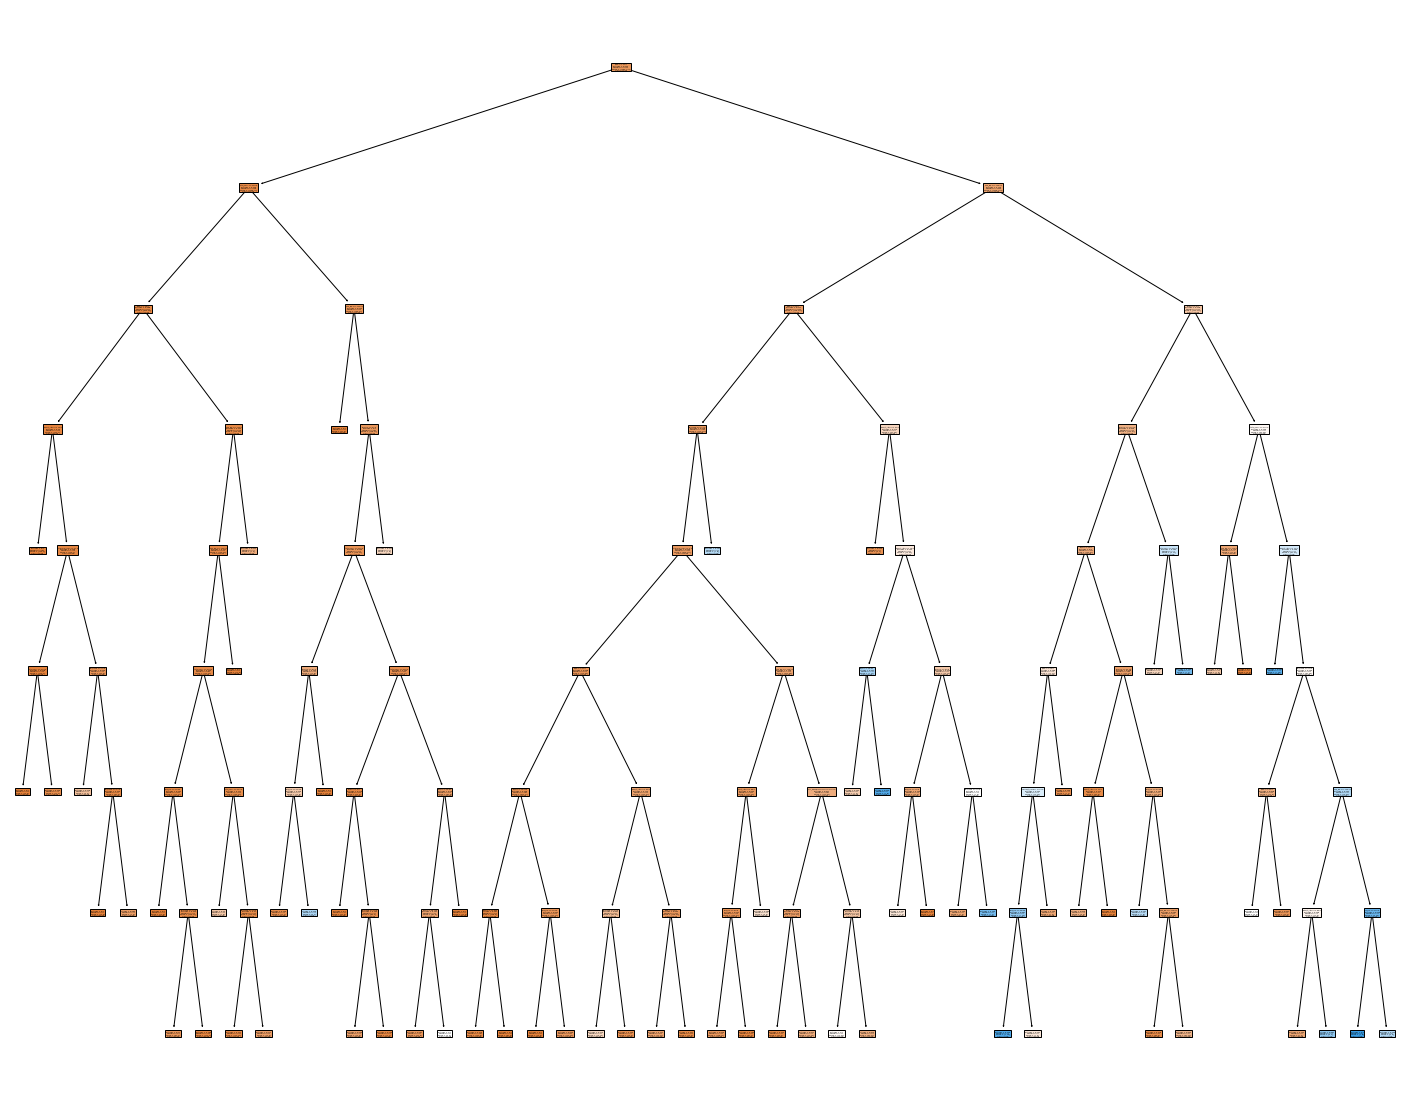

In [24]:
plot_dt = DecisionTreeClassifier(random_state = 42, criterion = dt.best_params_['criterion'], 
                                 max_depth = dt.best_params_['max_depth'], 
                                 min_samples_leaf = dt.best_params_['min_samples_leaf'])
plot_dt.fit(X2_train, c_train)

fig = plt.figure(figsize=(25, 20))
_ = plot_tree(plot_dt, feature_names = list(X2_train.columns), class_names = ['False', 'True'], filled = True)

# print(export_text(plot_dt, feature_names = list(X2_train.columns)))

### Decision Tree Classification with Cost Complexity Pruning

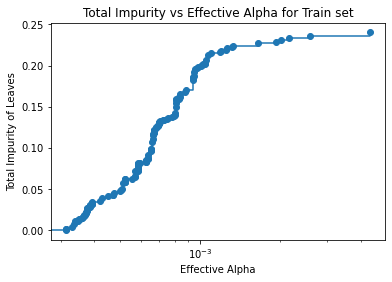

In [25]:
ccpdt = DecisionTreeClassifier(random_state = 42)
ccpdt_path = ccpdt.cost_complexity_pruning_path(X2_train, c_train)
ccpdt_alphas, ccpdt_impurities = ccpdt_path.ccp_alphas, ccpdt_path.impurities

plt.plot(ccpdt_alphas[:-1], ccpdt_impurities[:-1], marker = 'o', drawstyle = 'steps-post')
plt.xscale('log')
plt.xlabel('Effective Alpha')
plt.ylabel('Total Impurity of Leaves')
plt.title('Total Impurity vs Effective Alpha for Train set')
plt.show()

In [26]:
pdt = GridSearchCV(DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'), 
                  param_grid = {'ccp_alpha': ccpdt_alphas[:-1]}, 
                  scoring = mcc, cv = 5, return_train_score = True)

pdt.fit(X2_train, c_train)

pdt_df = pd.DataFrame(pdt.cv_results_)

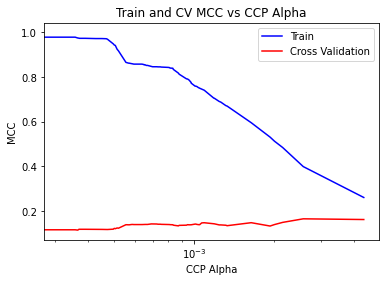

In [27]:
plt.plot(pdt_df['param_ccp_alpha'], pdt_df['mean_train_score'], c = 'b', label = 'Train')
plt.plot(pdt_df['param_ccp_alpha'], pdt_df['mean_test_score'], c = 'r', label = 'Cross Validation')
plt.xscale('log')
plt.legend(loc = 1)
plt.xlabel('CCP Alpha')
plt.ylabel('MCC')
plt.title('Train and CV MCC vs CCP Alpha')
plt.show()

Best Parameters: {'ccp_alpha': 0.002573784307376259}
Best Cross-Validation MCC: 0.17


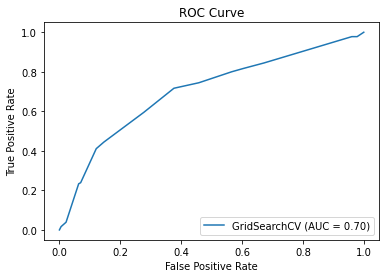

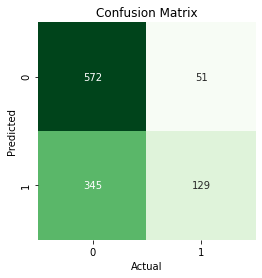

Accuracy: 0.64
Sensitivity: 0.72
Specificity: 0.62


In [28]:
print("Best Parameters: {}".format(pdt.best_params_))
print("Best Cross-Validation MCC: {:.2f}".format(pdt.best_score_))

pred_pdt = pdt.predict(X2_test)

plot_roc_curve(pdt, X2_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_pdt = confusion_matrix(c_test, pred_pdt)
tn, fp, fn, tp = cm_pdt.ravel()

ax = sns.heatmap(cm_pdt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_pdt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### Adaboost Decision Tree

In [29]:
adt_learning_rate_arr = np.logspace(-4, 0, 5)
adt_n_estimators_arr = [10, 20, 50, 100, 200, 500, 1000]

adt = GridSearchCV(AdaBoostClassifier(), 
                   param_grid = {'learning_rate' : adt_learning_rate_arr, 'n_estimators' : adt_n_estimators_arr}, 
                   scoring = mcc, cv = 5, return_train_score = True)

adt.fit(X2_train.values, c_train.values.ravel())

adt_df = pd.DataFrame(adt.cv_results_)

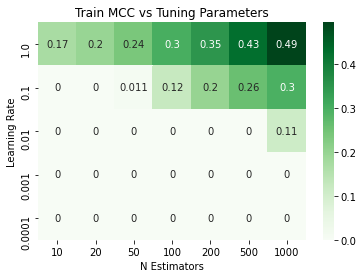

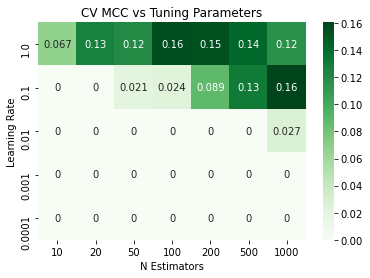

In [30]:
adt_train_err_mat = adt_df['mean_train_score'].values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_train_err_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'Train MCC vs Tuning Parameters')
plt.show()

adt_cv_err_mat = adt_df['mean_test_score'].values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_cv_err_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'CV MCC vs Tuning Parameters')
plt.show()

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 1000}
Best Cross-Validation MCC: 0.16


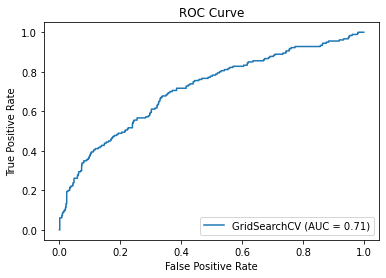

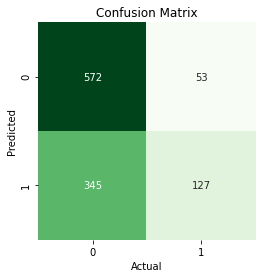

Accuracy: 0.64
Sensitivity: 0.71
Specificity: 0.62


In [43]:
print("Best Parameters: {}".format(adt.best_params_))
print("Best Cross-Validation MCC: {:.2f}".format(adt.best_score_))

pred_adt = (adt.predict_proba(X2_test)[:,1] >= 0.495).astype(bool)

plot_roc_curve(adt, X2_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_adt = confusion_matrix(c_test, pred_adt)
tn, fp, fn, tp = cm_adt.ravel()

ax = sns.heatmap(cm_adt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_adt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))